# Hall effect analysis

Use this template as a starting point to carry out the analysis tasks.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

## Standard Packages

This is a good idea at the beginning of your notebook to include the packages that you will need.  We will use those shown below here.  A brief description:
* `numpy` is the foundational package for Python numerical work. It extends and speeds up array operations beyond standard Python, and it includes almost all math functions that you would need for example `sqrt()` (square root) or `cos()` (cosine).  These would be written in code as `np.sqrt()` or `np.cos()`.
* `scipy` is a huge collection of scientific data analysis functions, routines, physicical constants, etc.  This is the second most used package for scientific work. Here we will use the physical constants library, `scipy.constants`.  Documentation is at [SciPy.org](https://docs.scipy.org/doc/scipy/reference/) with the constants subpackage at https://docs.scipy.org/doc/scipy/reference/constants.html.
* `uncertainties` is a very useful small package that simplifies uncertainty propagation and printing out of quantities with uncertainty. Documentation is at https://pythonhosted.org/uncertainties/
* `matplotlib` is *the* standard plotting package for scientific Python.  We will use a subset called `pyplot` which is modeled after the plotting functions used in MATLAB. The last line below, `%matplotlib inline`, simply forces the plots to appear within the notebook.
* `pandas` is a large data science package.  It's main feature is a set of methods to create and manipulate a "DataFrame," which is an enlargement of the idea of an array.  I plays well with NumPy and other packages.  We will use it mainly as a way to read files into data sets in an easy way.
* [LMFit](https://lmfit.github.io/lmfit-py/) is excellent for carrying out line and curve fits with many useful features.

## Getting Help

See the example code for a wide range of actions in notebooks created by Prof. Marjorie Olmstead and Prof. David Pengra in this repository: [**Physics431/Examples**](https://github.com/Physics431/Examples).

You can pull the examples into your environment with the following command.  (Only do this once, or you will get an error):

    git clone https://github.com/Physics431/Examples

## Task Summary

1. If not already done, enter the raw data into a spreadsheet, save the file(s) and make them available to the members of the group.  You should have at least 4 different tables: measurements for each probe plus the measurements of the magnetic field
2. Import the magnetic field measurements.  Calculate a mean and standard deviation for the magnetic field $B$ at the location of the probes between the poles.
3. Import the measurements from each probe. Calculate $2V_H$ for each value of $I_x$  for each probe, as described in the instructions.  Show a code snippet that does this or describe the calculation in your group notebook with an example.
4. Plot $2V_H$ versus $I_x$  for each sample and fit a line to it using LMfit.  Obtain the fit coefficients and their uncertainty.
5. Calculate the Hall coefficient $R_H$ for each probe and propagate the uncertainty from the fit, uncertainty in the magnetic field, and uncertainties in the probe specifications given in Table 1 in the instructions.
6. Determine the source of the largest statistical uncertainty, and explain how this was determined. 
7. Calculate the conductivity of the sample material and its uncertainty for all three samples.
8. Calculate the Hall mobility $\mu$ for the InAs probe.  (You can also calculate a mobility for the metal probes, but its meaning is suspect.)

In [1]:
# Usually import packages via a handle to the functions in them using import ... as ...
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uncertainties as unc
%matplotlib inline

In [2]:
# Useful plot default
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

## Read in the B-field data

If the data files are spreadsheet files with comma-separated values (CSV) they can be read in with Pandas `pd.read_csv()`:
    
    B_data = pd.read_csv('Hall_magnet_measurements.csv')


In [7]:
b_data = pd.read_csv("./data/b_data.csv")
b_data

,B (T)
0,-0.13337
1,-0.13465
2,-0.13314
3,-0.13212
4,-0.13488
5,0.13397
6,0.13314
7,0.13219
8,0.13174
9,0.13426


Calculate the average value of the field and its standard deviation, correcting for the sign reversal.  One way to do this is to create a new NumPy array that holds all values as absolute-values, and then use the methods within the array.  

In [29]:
# You code this
b_data_abs = np.abs(b_data)
b_avg = np.mean(b_data_abs)
b_std = np.std(b_data_abs).iloc[0]

print(f"Average B: {b_avg:.4f} T")
print(f"Standard deviation: {b_std:.4f} T")

Average B: 0.1333 T
Standard deviation: 0.0010 T


In [30]:
# Create an uncertainty object that holds the feild and its uncertainty.
# You need the values of B and its uncertainty 
uB = unc.ufloat(b_avg, b_std, "B")
print(f"The field strength of the magnet = {uB:.4uP} T")

The field strength of the magnet = 0.133346±0.001038 T


## Read in the probe data

As before, use `pd.read_csv()`.

Then for each, create an array that gives $2V_H$, twice the hall voltage.  Be careful with signs! 

In [108]:
def import_probe_data(file_path):
    data = pd.read_csv(file_path)
    data["2V_H (mV)"] = data["mV down green"] - data["mV up green"]
    return data


al_data = import_probe_data("./data/au_data.csv")

print(al_data)

   mV up green  mV down green      A  2V_H (mV)
0     -0.03592       -0.03088  0.050    0.00504
1     -0.04813       -0.04097  0.065    0.00716
2     -0.05986       -0.05096  0.080    0.00890
3     -0.07152       -0.06112  0.095    0.01040
4     -0.07924       -0.06768  0.105    0.01156
5     -0.09089       -0.07758  0.120    0.01331
6     -0.10252       -0.08741  0.135    0.01511
7     -0.11415       -0.09771  0.150    0.01644
8     -0.12572       -0.10744  0.165    0.01828
9     -0.13733       -0.11743  0.180    0.01990


In [166]:
AU = "Au"
INAS = "InAs"
AL = "Al"

probe_data_files = [
    {
        "file": "./data/au_data.csv",
        "name": AU,
        "color": "red",
        "thickness": unc.ufloat(1.37e-7, 0.16e-7, "t_Au"),
        "width": unc.ufloat(12.7e-3, 0.05e-3, "w_Au"),
        "length": unc.ufloat(30.5e-3, 0.05e-3, "l_Au"),
        "resistance": unc.ufloat(0.77, 0.006, "R_Au"),
    },
    {
        "file": "./data/inas_data.csv",
        "name": INAS,
        "color": "blue",
        "thickness": unc.ufloat(1.26e-4, 0.02e-4, "t_InAs"),
        "width": unc.ufloat(0.692e-3, 0.004e-3, "w_InAs"),
        "length": unc.ufloat(1.542e-3, 0.005e-3, "l_InAs"),
        "resistance": unc.ufloat(1.3, 0.3, "R_InAs"),
    },
    {
        "file": "./data/al_data.csv",
        "name": AL,
        "color": "green",
        "thickness": unc.ufloat(2.34e-7, 0.17e-7, "t_Al"),
        "width": unc.ufloat(12.7e-3, 0.05e-3, "w_Al"),
        "length": unc.ufloat(30.5e-3, 0.05e-3, "l_Al"),
        "resistance": unc.ufloat(0.872, 0.018, "R_Al"),
    },
]


probe_data_dict = {
    file["name"]: {
        **file,
        "data": import_probe_data(file["file"]),
    }
    for file in probe_data_files
}

for name, data in probe_data_dict.items():
    print("-" * 40)
    print(f"{name:^40}")
    print("-" * 40)
    print(data["data"])
    print("")

----------------------------------------
                   Au                   
----------------------------------------
   mV up green  mV down green      A  2V_H (mV)
0     -0.03592       -0.03088  0.050    0.00504
1     -0.04813       -0.04097  0.065    0.00716
2     -0.05986       -0.05096  0.080    0.00890
3     -0.07152       -0.06112  0.095    0.01040
4     -0.07924       -0.06768  0.105    0.01156
5     -0.09089       -0.07758  0.120    0.01331
6     -0.10252       -0.08741  0.135    0.01511
7     -0.11415       -0.09771  0.150    0.01644
8     -0.12572       -0.10744  0.165    0.01828
9     -0.13733       -0.11743  0.180    0.01990

----------------------------------------
                  InAs                  
----------------------------------------
   mV up green  mV down green      A  2V_H (mV)
0     -9.65954        9.78612  0.055   19.44566
1    -10.53882       10.69285  0.060   21.23167
2    -11.40776       11.57443  0.065   22.98219
3    -12.28612       12.45594  0.

## Make a couple of plots

The metal probes typically have similar Hall voltages. You should plot them on the same graph to compare, but InAs has much higher values and would need its own plot.

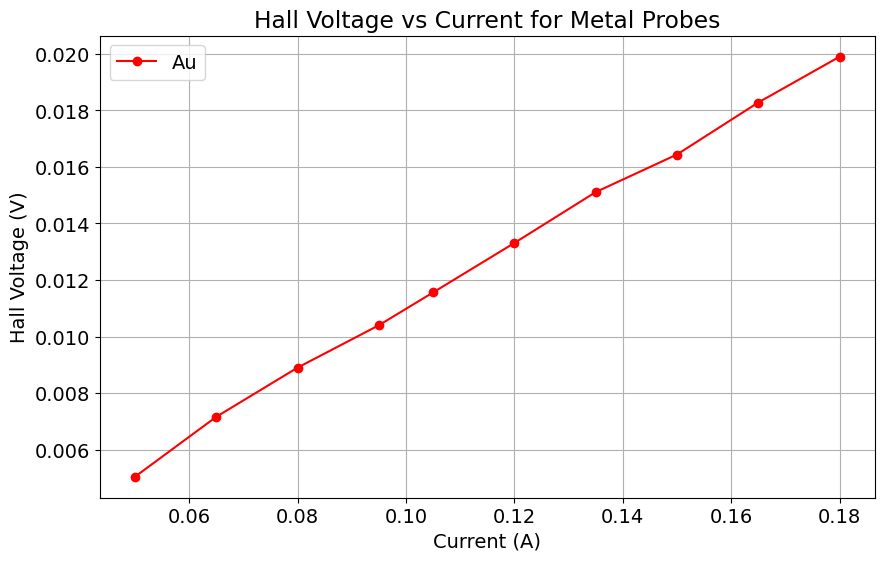

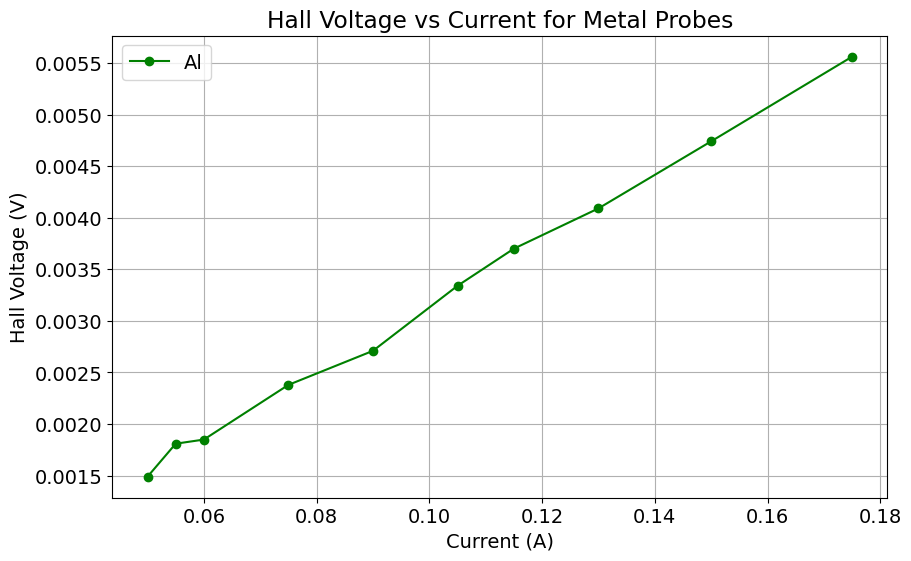

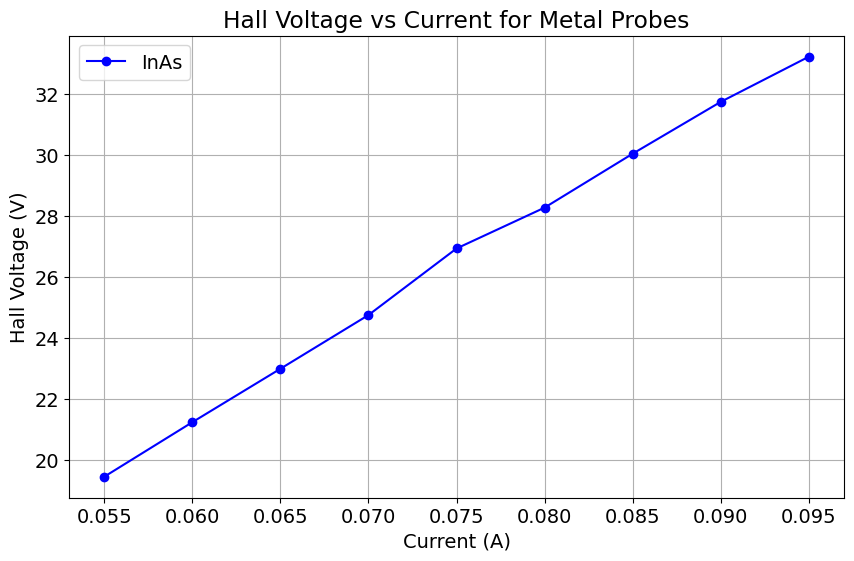

In [152]:
def make_probe_plot(config):
    plt.figure(figsize=(10, 6))

    data = config["data"]
    color = config["color"]
    plt.plot(
        data["A"],
        data["2V_H (mV)"],
        "o-",
        label=f"{config['name']}",
        color=color,
    )

    plt.xlabel("Current (A)")
    plt.ylabel("Hall Voltage (V)")
    plt.title("Hall Voltage vs Current for Metal Probes")
    plt.grid(True)
    plt.legend()
    plt.show()


make_probe_plot(probe_data_dict[AU])
make_probe_plot(probe_data_dict[AL])
make_probe_plot(probe_data_dict[INAS])

## Fit the data to extract the slope of $2V_H/I_x$

Use LMfit.  See the examples.

In [153]:
# Set  up the Model  This cell does the import and model instance creation

# Import the Linear model.
# You only do this once in a notebook
from lmfit.models import LinearModel

# create an instance of the model
# You only need to do this once
line = LinearModel()


In [154]:
def calculate_fit(data):
    param_guess = line.guess(data["2V_H (mV)"], x=data["A"])
    fit = line.fit(data["2V_H (mV)"], param_guess, x=data["A"])
    return {
        "fit": fit,
        "slope": fit.params["slope"].value,
        "slope_uncertainty": unc.ufloat(
            fit.params["slope"].value,
            fit.params["slope"].stderr,
            "slope",
        ),
        "intercept": fit.params["intercept"].value,
        "intercept_uncertainty": unc.ufloat(
            fit.params["intercept"].value,
            fit.params["intercept"].stderr,
            "intercept",
        ),
    }


probe_fit_dict = {
    AU: calculate_fit(probe_data_dict[AU]["data"]),
    AL: calculate_fit(probe_data_dict[AL]["data"]),
    INAS: calculate_fit(probe_data_dict[INAS]["data"]),
}

probe_fit_dict

{'Au': {'fit': <lmfit.model.ModelResult at 0x13d797ed0>,
  'slope': 0.11258730866136454,
  'slope_uncertainty': < slope = 0.11258730866136454+/-0.0012775057839495075 >,
  'intercept': -0.0002812468416875984,
  'intercept_uncertainty': < intercept = -0.0002812468416875984+/-0.0001553759024400994 >},
 'Al': {'fit': <lmfit.model.ModelResult at 0x13d794050>,
  'slope': 0.03203690494674507,
  'slope_uncertainty': < slope = 0.03203690494674507+/-0.00052587006111525 >,
  'intercept': -5.270894715170038e-05,
  'intercept_uncertainty': < intercept = -5.270894715170038e-05+/-5.691192140292201e-05 >},
 'InAs': {'fit': <lmfit.model.ModelResult at 0x13d7947d0>,
  'slope': 347.10529999999994,
  'slope_uncertainty': < slope = 347.10529999999994+/-4.955859914801504 >,
  'intercept': 0.47204805555555157,
  'intercept_uncertainty': < intercept = 0.47204805555555157+/-0.3771558088457616 >}}

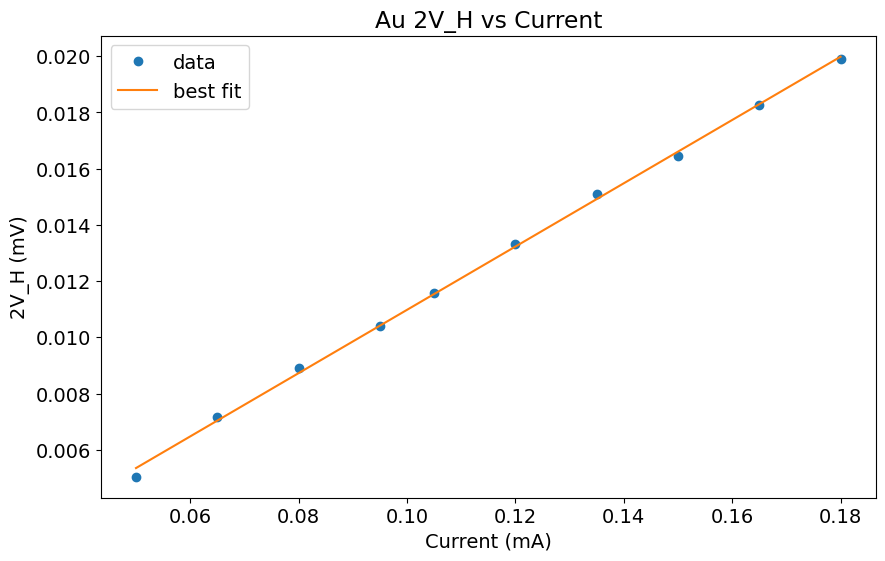

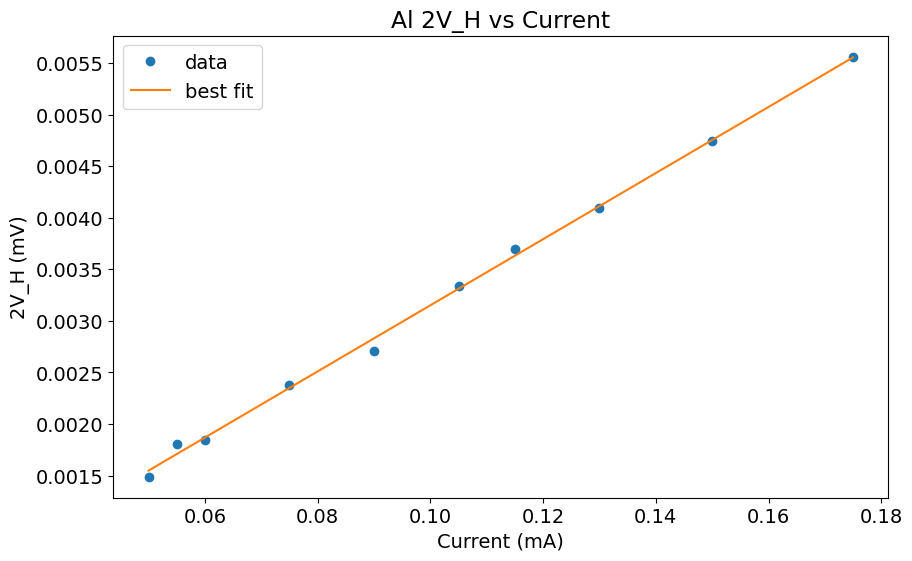

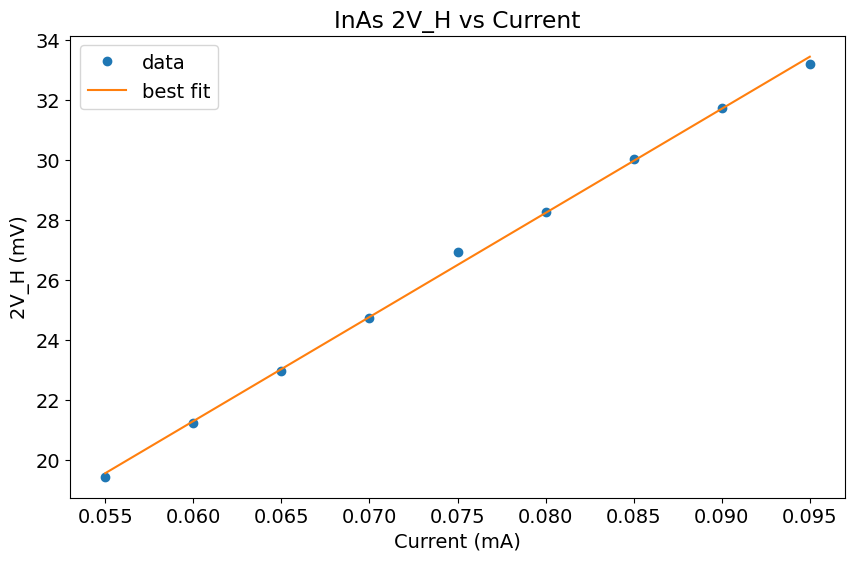

In [155]:
def make_fit_plot(fit, config):
    plt.figure(figsize=(10, 6))

    fit.plot_fit(
        xlabel="Current (mA)",
        ylabel="2V_H (mV)",
        title=f"{config['name']} 2V_H vs Current",
    )

    plt.show()


make_fit_plot(probe_fit_dict[AU]["fit"], probe_data_dict[AU])
make_fit_plot(probe_fit_dict[AL]["fit"], probe_data_dict[AL])
make_fit_plot(probe_fit_dict[INAS]["fit"], probe_data_dict[INAS])

### Extract the slope with uncertainty from the fit parameters


In [156]:
for name, data in probe_data_dict.items():
    print(
        "2VH/Ix for {} = {:.2uP} mV/mA".format(
            name, probe_fit_dict[name]["slope_uncertainty"]
        )
    )

2VH/Ix for Au = 0.1126±0.0013 mV/mA
2VH/Ix for InAs = 347.1±5.0 mV/mA
2VH/Ix for Al = 0.03204±0.00053 mV/mA


### Calculate the Hall coefficient

The Hall coefficient $R_H$ is related to the measurements by

$$V_H = -R_H\frac{I_xB_z}{t}$$ 

where $t$ is the thichness of the sample strip.  From the linefit, we have the slope $m = 2V_H/I_x$  so

$$R_H = -m\frac{t}{2B_z}$$

In the instructions there is a list of probe parameters.  Use these to calculate the Hall coefficient and its statistical uncertainty.


In [159]:
# Calculate the Hall coefficient for each probe
for name, data in probe_data_dict.items():
    RH = -probe_fit_dict[name]["slope_uncertainty"] * data["thickness"] / (2 * uB)
    probe_fit_dict[name]["RH"] = RH
    print("The Hall coefficient for the {} probe is {:.2uP} m^3/A-s".format(name, RH))


The Hall coefficient for the Au probe is (-5.78±0.68)×10⁻⁸ m^3/A-s
The Hall coefficient for the InAs probe is -0.1640±0.0037 m^3/A-s
The Hall coefficient for the Al probe is (-2.81±0.21)×10⁻⁸ m^3/A-s


In [160]:
# Here is an example of how to extract the relative contributions of the different
# quantities that go into the calculation.  See how the "tags" are used.

for name, data in probe_data_dict.items():
    print("\nPercent contribution to statistical uncertainty:")
    RH = probe_fit_dict[name]["RH"]
    for var, error in RH.error_components().items():
        print("{:>6s}: {:.3%}".format(var.tag, (error / RH.s) ** 2))


Percent contribution to statistical uncertainty:
     B: 0.438%
  t_Au: 98.630%
 slope: 0.931%

Percent contribution to statistical uncertainty:
     B: 11.742%
t_InAs: 48.786%
 slope: 39.472%

Percent contribution to statistical uncertainty:
     B: 1.081%
  t_Al: 94.114%
 slope: 4.804%


## Repeat above for other samples

### Gold probe

Comments are minimal.

<Axes: title={'center': 'Au 2V_H vs Current'}, xlabel='Current (mA)', ylabel='2V_H (mV)'>

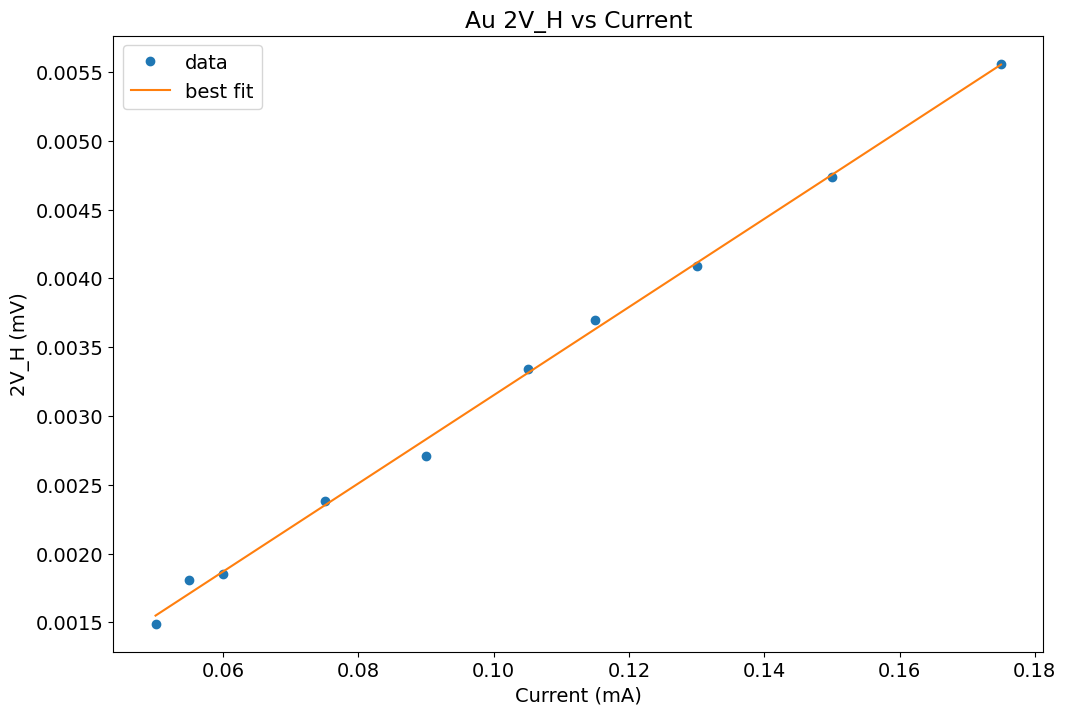

In [161]:
probe_fit_dict[AL]["fit"].plot_fit(
    xlabel="Current (mA)", ylabel="2V_H (mV)", title="Au 2V_H vs Current"
)

<Axes: title={'center': 'Au 2V_H vs Current'}, xlabel='Current (mA)', ylabel='2V_H (mV)'>

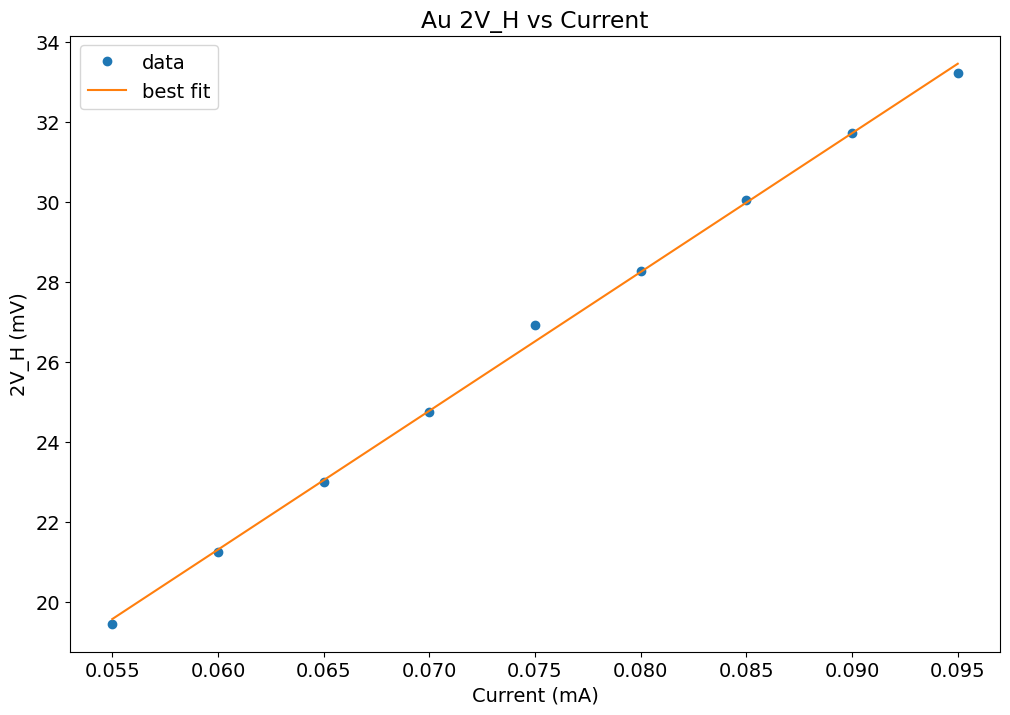

In [162]:
probe_fit_dict[INAS]["fit"].plot_fit(
    xlabel="Current (mA)", ylabel="2V_H (mV)", title="Au 2V_H vs Current"
)

## Conductivity calculations

From equation (13) in the instructions

$$\sigma = \frac{\ell}{Rwt}$$

We use the data in table 1.

In [169]:
# Calculate the conductivity for each sample from the above
for name, data in probe_data_dict.items():
    sigma = data["length"] / (data["resistance"] * data["width"] * data["thickness"])
    print(f"The conductivity for the {name} probe is {sigma:.2uP} S/m")

# Calculate the Hall coefficient for each probe

The conductivity for the Au probe is (2.28±0.27)×10⁷ S/m
The conductivity for the InAs probe is (1.36±0.31)×10⁴ S/m
The conductivity for the Al probe is (1.177±0.089)×10⁷ S/m


### Calculate mobility for InAs probe

(Metal probe "mobility" is optional, because it does not mean very much.) From exercise 4

$$\mu = \sigma R_H$$.

In [ ]:
# Calculate the Carrier density of the InAs probe from the Hall coefficient and charge of the electron

# Scientific constants are in SciPy
import scipy.constants as const 
const.e # electron charge in coulombs

# Calculate the carrier density and print it WITH UNITS

# Claculate the mobility and print it WITH UNITS

In [ ]:
# Optional: Mobility for metals, just because we can
